In [1]:
import json
import math
import os

from iterpop import iterpop as ip
import pandas as pd
import seaborn as sns
from slugify import slugify
from teeplot import teeplot as tp


# load data from JSON

The source json file was manually extracted from notebook file provided by Emily.
(The notebook can also be found in `assets/`.)


In [2]:
with open("assets/reconstruction_quality.json") as file:
    data = json.load(file)

records = [
    {
        data['columns'][int(k) - 1]['label'][0] : v
        for k, v in row.items()
    }
    for row in data['data']
]

df = pd.DataFrame.from_records(records)


In [3]:
df


,Treatment,target,differentia,policy,condition,score,dist_fun
0,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,random,0.53078963,info
1,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,ecoea,0.77343524,info
2,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,sharing,0.83529931,info
3,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,tournament,NaN,info
4,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,lexicase,0.55516873,info
...,...,...,...,...,...,...,...
280,trueTree,NA,NA,NA,random,1.00000000,rf
281,trueTree,NA,NA,NA,ecoea,1.00000000,rf
282,trueTree,NA,NA,NA,sharing,1.00000000,rf
283,trueTree,NA,NA,NA,tournament,NaN,rf


In [4]:
numeric_cols = [
    "target",
    "differentia",
    "score",
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce').astype({
    "differentia" : "Int64",
    "target" : "Int64",
})

df


,Treatment,target,differentia,policy,condition,score,dist_fun
0,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,random,0.530790,info
1,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,ecoea,0.773435,info
2,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,sharing,0.835299,info
3,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,tournament,NaN,info
4,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,lexicase,0.555169,info
...,...,...,...,...,...,...,...
280,trueTree,<NA>,<NA>,NA,random,1.000000,rf
281,trueTree,<NA>,<NA>,NA,ecoea,1.000000,rf
282,trueTree,<NA>,<NA>,NA,sharing,1.000000,rf
283,trueTree,<NA>,<NA>,NA,tournament,NaN,rf


In [5]:
df["Tree Comparison Metric"] = df["dist_fun"].apply(
    lambda x: {
        "rf" : "Generalized Robinson-Foulds Similarity",
        "info" : "Mutual Clustering Information",
        "cid" : "Clustering Information Distance",
    }[x]
)
df["Num Column Bits"] = df["target"]
df["Num Differentia Bits"] = df["differentia"]


In [6]:
# filter out trueTree rows
df_results = df[df['Treatment'] != "trueTree"]

# save as csv for inclusion in PDF appendices
os.makedirs("outplots", exist_ok=True)
df_results.to_csv("outplots/reconstruction_quality_results.csv", index=False)

df_results


,Treatment,target,differentia,policy,condition,score,dist_fun,Tree Comparison Metric,Num Column Bits,Num Differentia Bits
0,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,random,0.530790,info,Mutual Clustering Information,4096,1
1,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,ecoea,0.773435,info,Mutual Clustering Information,4096,1
2,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,sharing,0.835299,info,Mutual Clustering Information,4096,1
3,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,tournament,NaN,info,Mutual Clustering Information,4096,1
4,differentia=1+policy=RecencyProportionalResolu...,4096,1,RPR,lexicase,0.555169,info,Mutual Clustering Information,4096,1
...,...,...,...,...,...,...,...,...,...,...
265,differentia=8+policy=TaperedDepthProportionalR...,64,8,TDPR,random,0.322231,rf,Generalized Robinson-Foulds Similarity,64,8
266,differentia=8+policy=TaperedDepthProportionalR...,64,8,TDPR,ecoea,0.087059,rf,Generalized Robinson-Foulds Similarity,64,8
267,differentia=8+policy=TaperedDepthProportionalR...,64,8,TDPR,sharing,0.277794,rf,Generalized Robinson-Foulds Similarity,64,8
268,differentia=8+policy=TaperedDepthProportionalR...,64,8,TDPR,tournament,0.000000,rf,Generalized Robinson-Foulds Similarity,64,8


# plot scores


Clustering Information Distance
teeplots/col=num-differentia-bits+hue=policy+kind=bar+row=num-column-bits+tree-comparison-metric=clustering-information-distance+viz=catplot+x=condition+y=score+ext=.pdf
teeplots/col=num-differentia-bits+hue=policy+kind=bar+row=num-column-bits+tree-comparison-metric=clustering-information-distance+viz=catplot+x=condition+y=score+ext=.png
Generalized Robinson-Foulds Similarity
teeplots/col=num-differentia-bits+hue=policy+kind=bar+row=num-column-bits+tree-comparison-metric=generalized-robinson-foulds-similarity+viz=catplot+x=condition+y=score+ext=.pdf
teeplots/col=num-differentia-bits+hue=policy+kind=bar+row=num-column-bits+tree-comparison-metric=generalized-robinson-foulds-similarity+viz=catplot+x=condition+y=score+ext=.png
Mutual Clustering Information
teeplots/col=num-differentia-bits+hue=policy+kind=bar+row=num-column-bits+tree-comparison-metric=mutual-clustering-information+viz=catplot+x=condition+y=score+ext=.pdf
teeplots/col=num-differentia-bits+hue

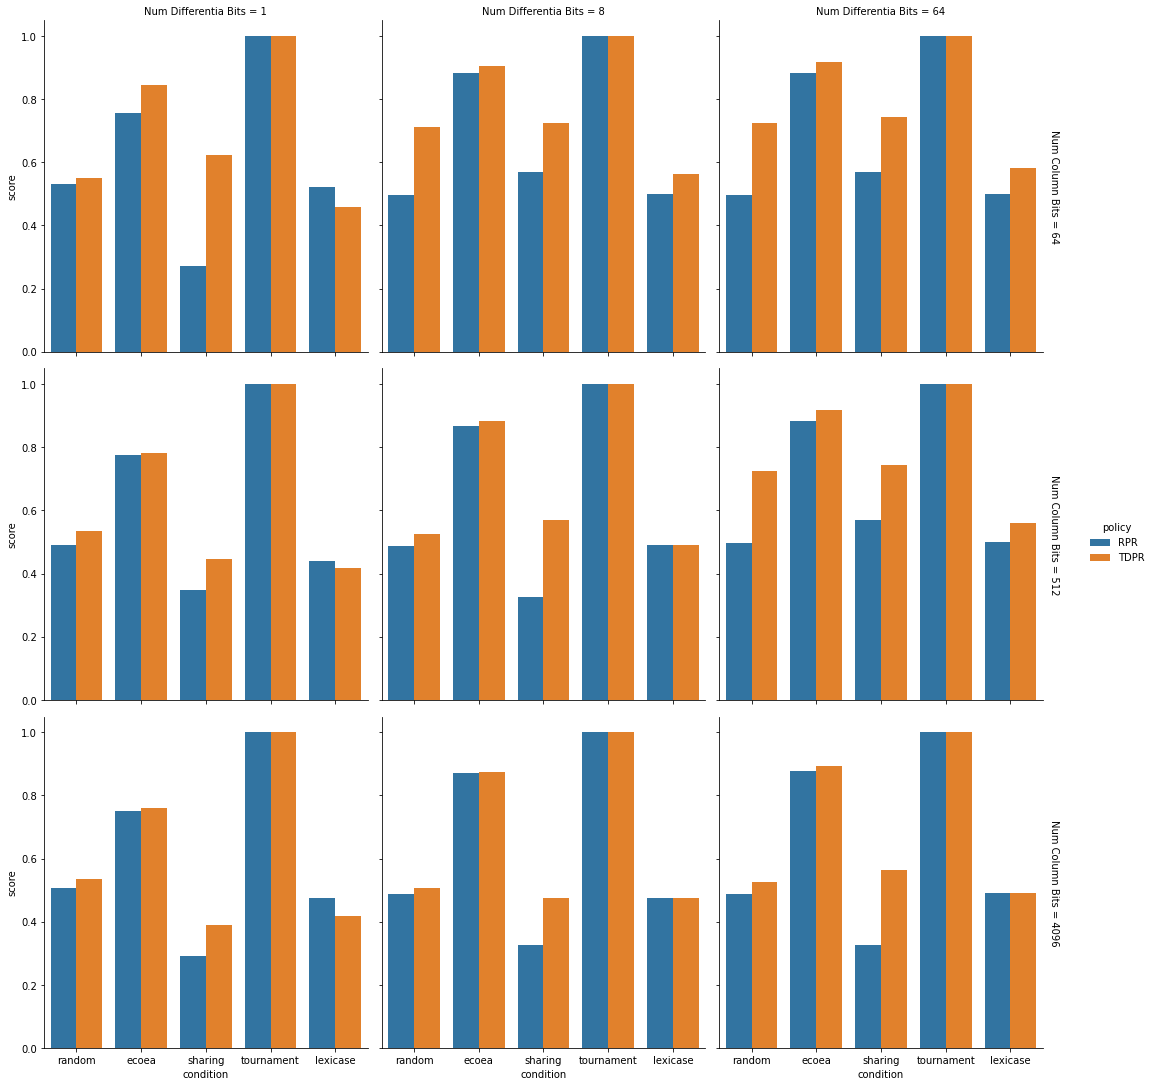

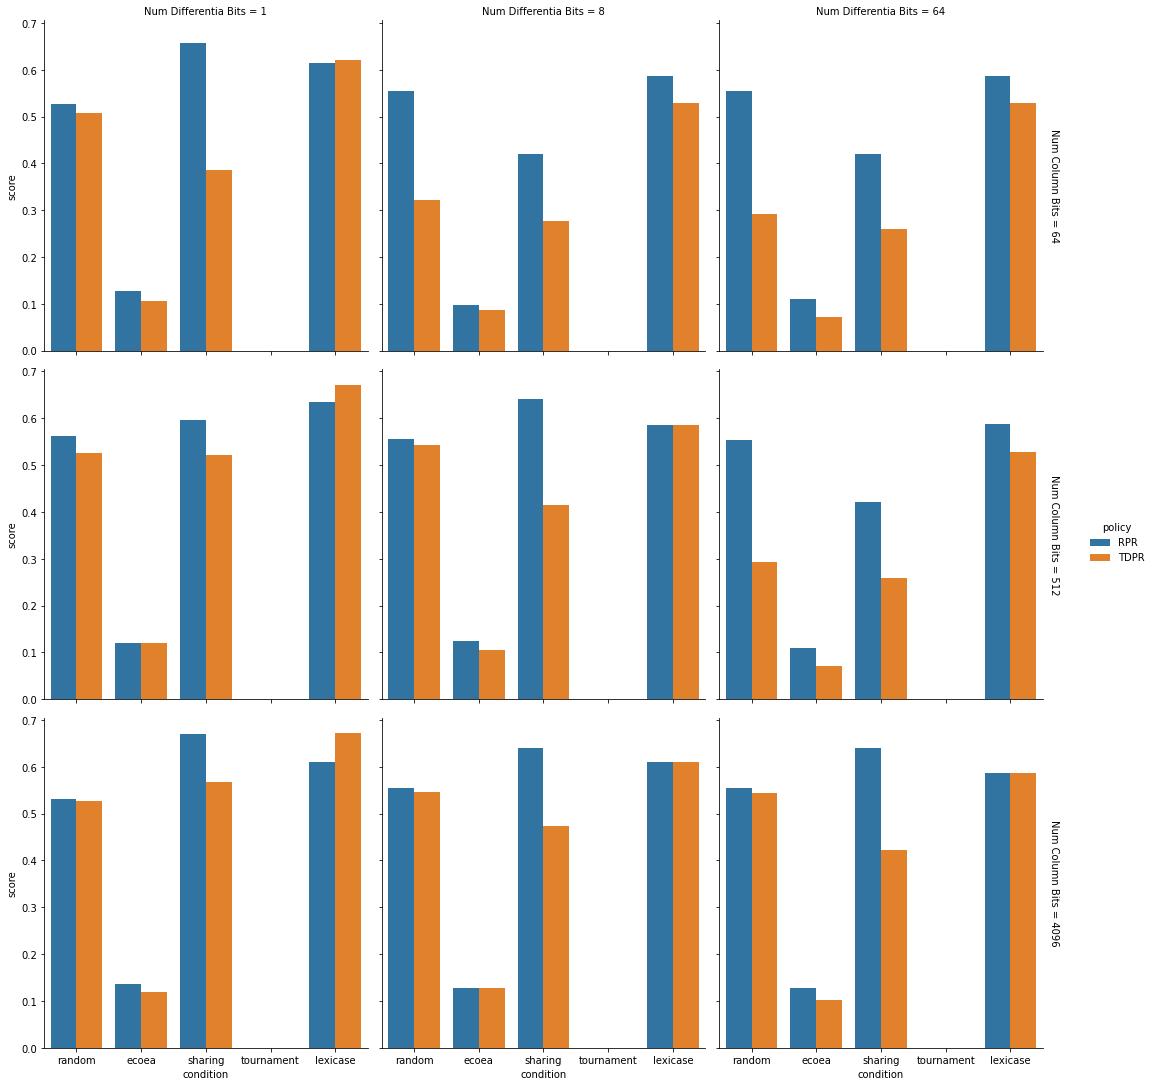

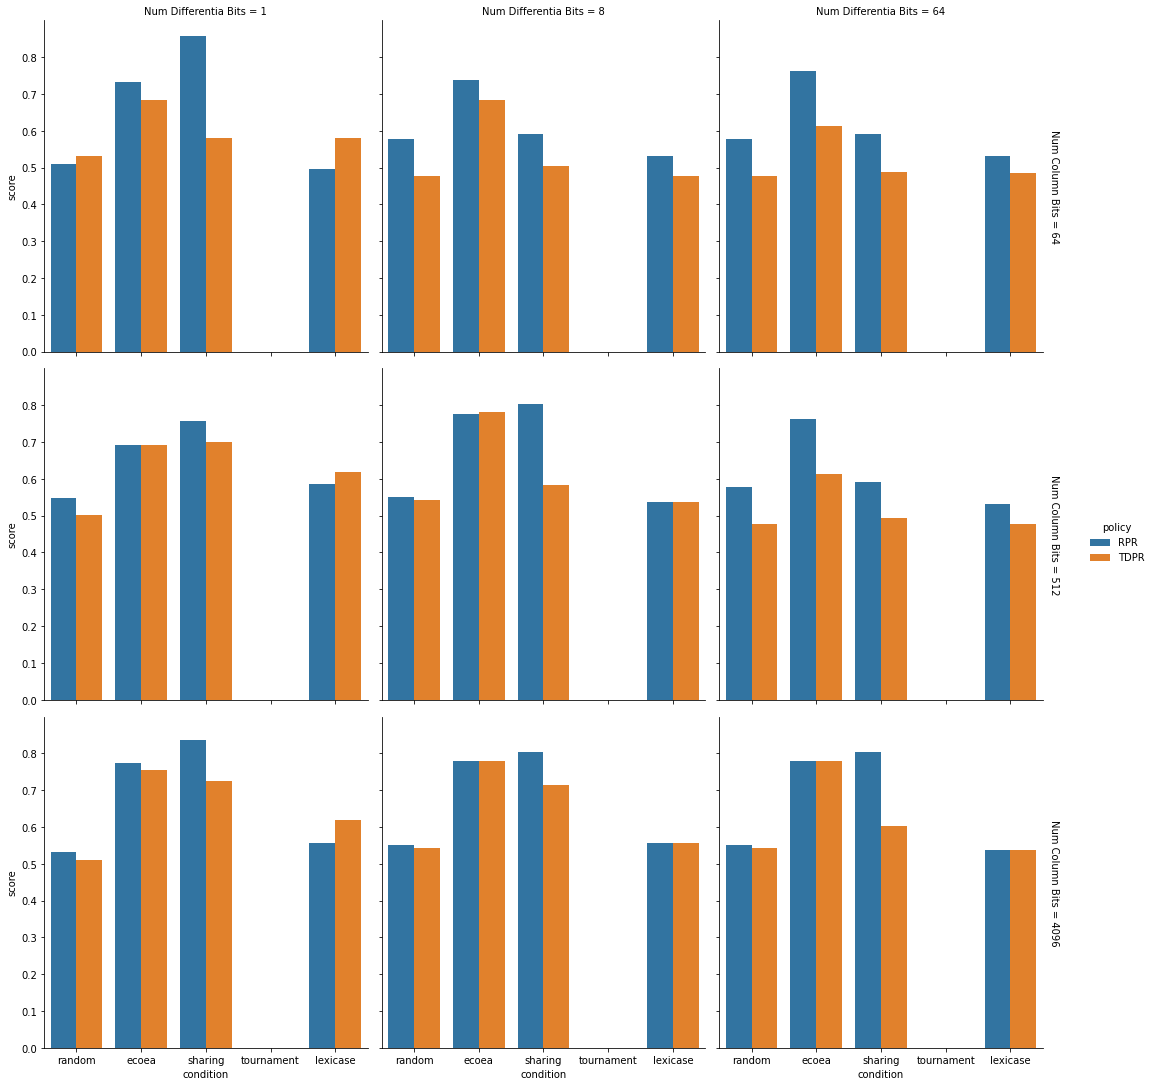

In [7]:
for metric, df_group in df_results.groupby("Tree Comparison Metric"):
    print(metric)
    tp.tee(
        sns.catplot,
        x="condition",
        y="score",
        hue="policy",
        col="Num Differentia Bits",
        row="Num Column Bits",
        data=df_group,
        kind="bar",
        margin_titles=True,
        teeplot_outattrs={
            "tree-comparison-metric" : slugify(metric),
        }
    )


Clustering Information Distance
teeplots/col=condition+hue=num-differentia-bits+kind=bar+row=policy+tree-comparison-metric=clustering-information-distance+viz=catplot+x=num-column-bits+y=score+ext=.pdf
teeplots/col=condition+hue=num-differentia-bits+kind=bar+row=policy+tree-comparison-metric=clustering-information-distance+viz=catplot+x=num-column-bits+y=score+ext=.png
Generalized Robinson-Foulds Similarity
teeplots/col=condition+hue=num-differentia-bits+kind=bar+row=policy+tree-comparison-metric=generalized-robinson-foulds-similarity+viz=catplot+x=num-column-bits+y=score+ext=.pdf
teeplots/col=condition+hue=num-differentia-bits+kind=bar+row=policy+tree-comparison-metric=generalized-robinson-foulds-similarity+viz=catplot+x=num-column-bits+y=score+ext=.png
Mutual Clustering Information
teeplots/col=condition+hue=num-differentia-bits+kind=bar+row=policy+tree-comparison-metric=mutual-clustering-information+viz=catplot+x=num-column-bits+y=score+ext=.pdf
teeplots/col=condition+hue=num-differ

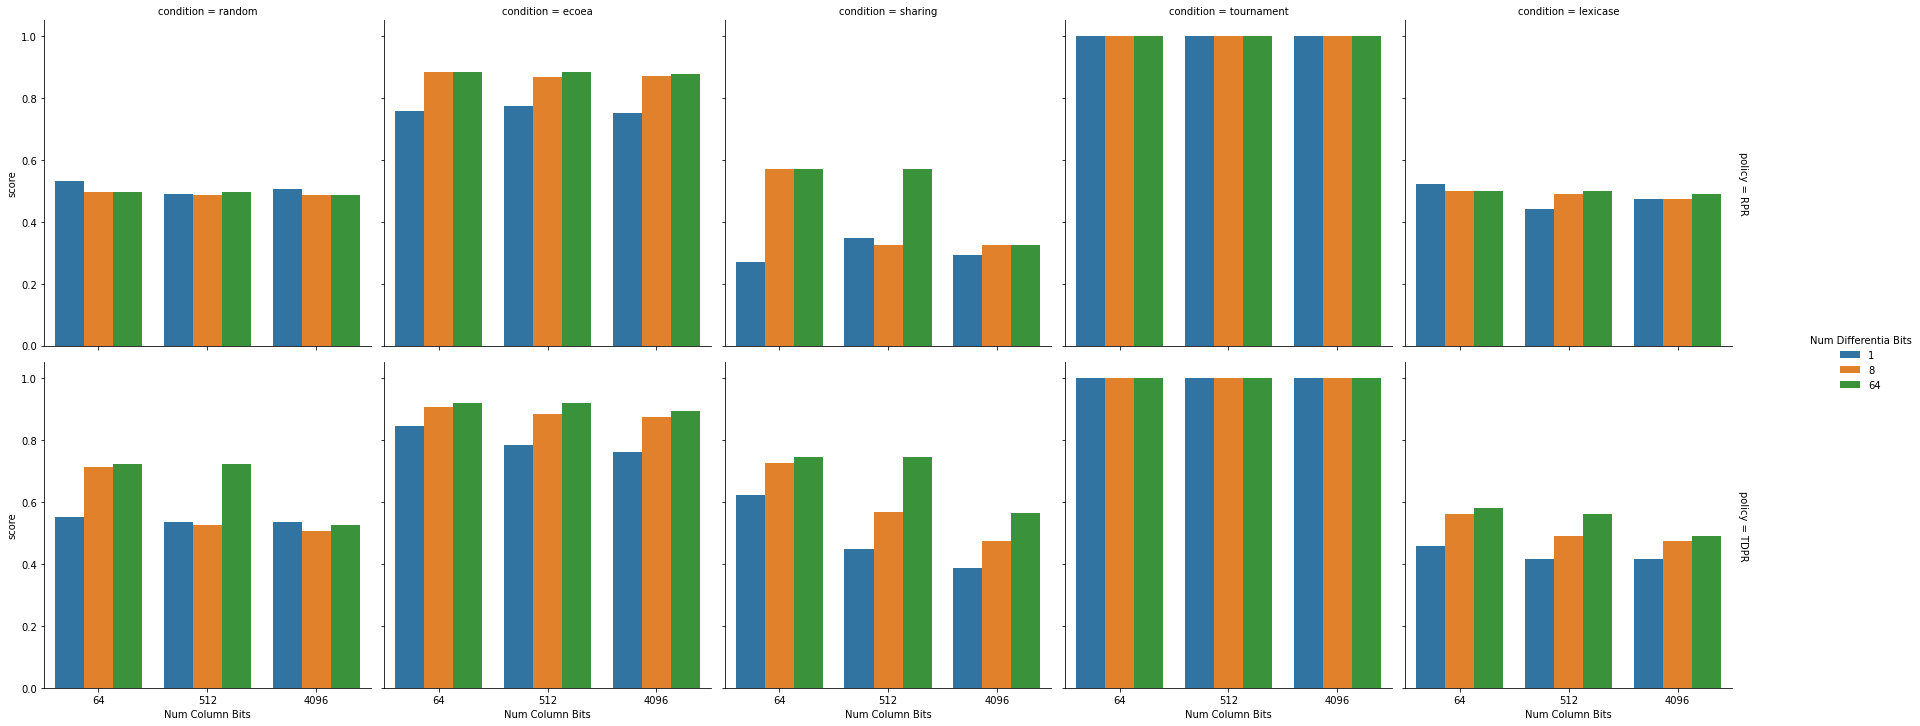

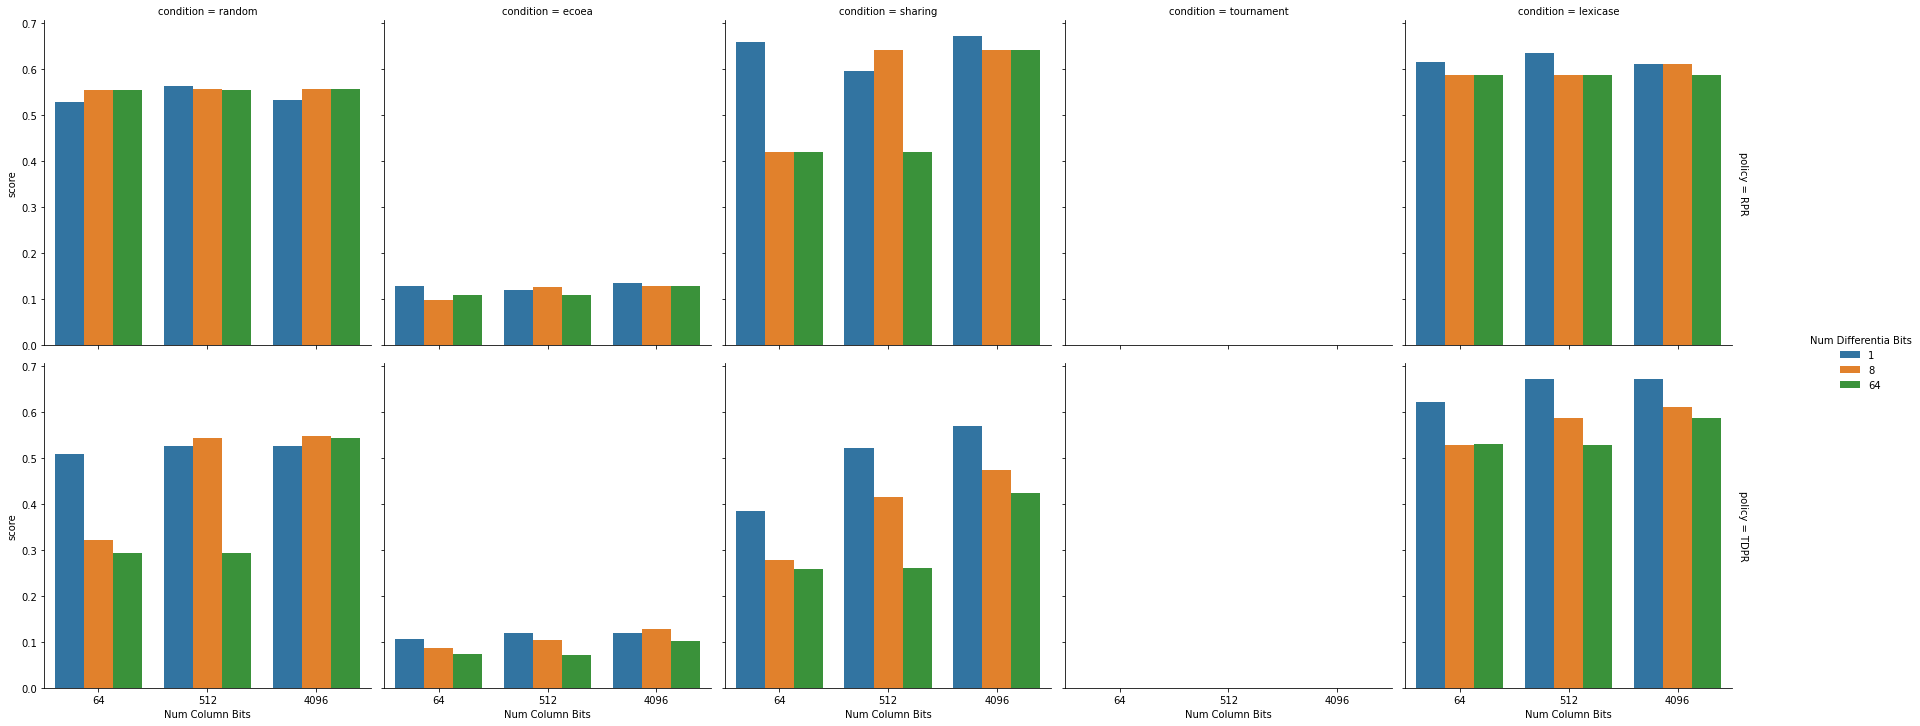

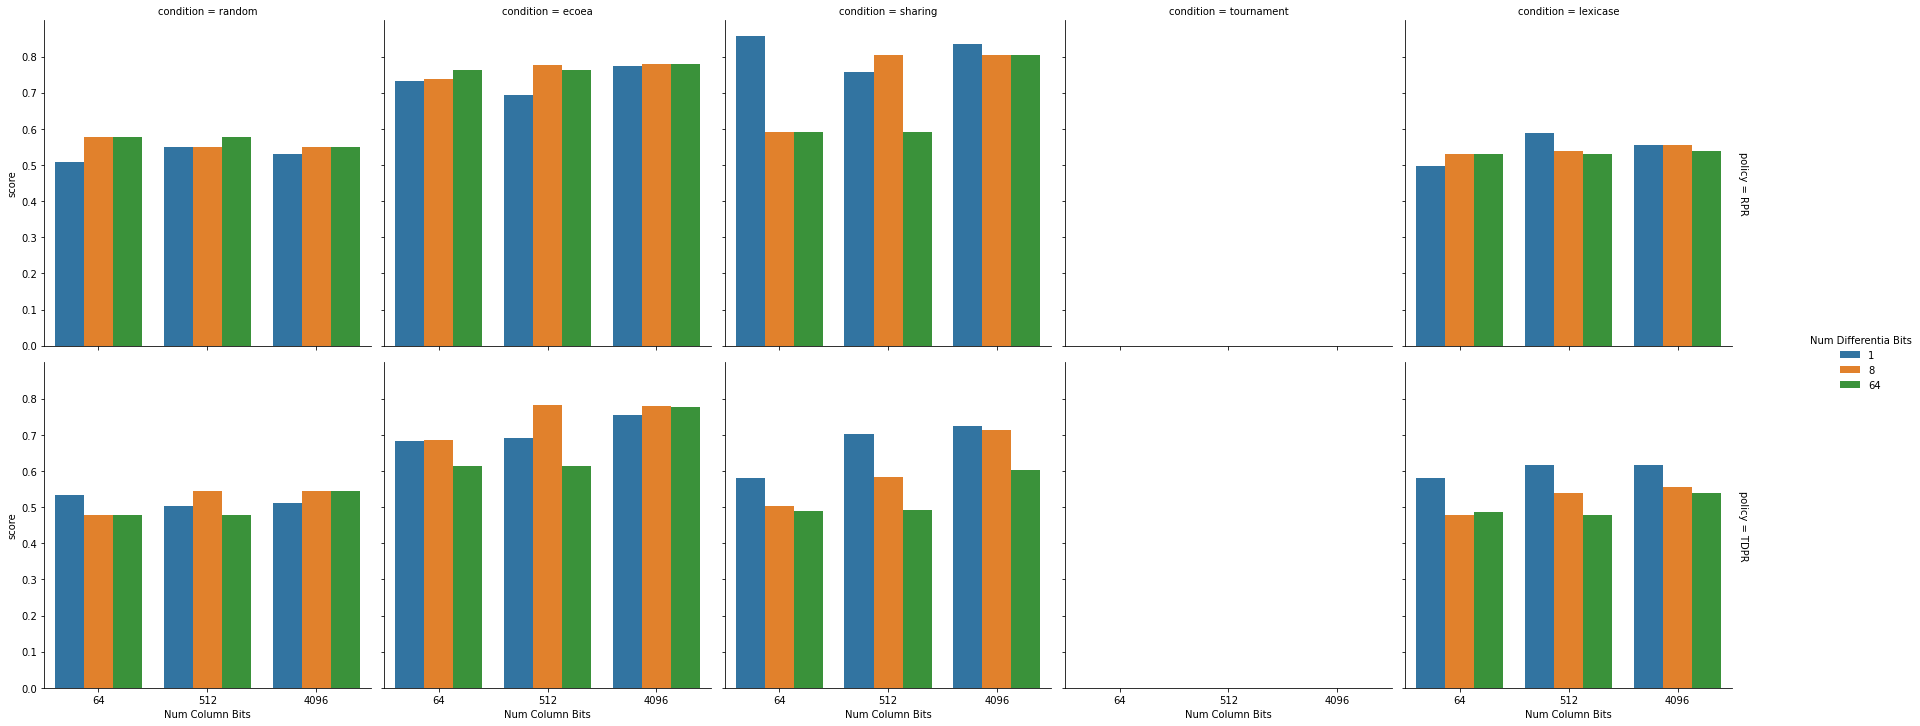

In [8]:
for metric, df_group in df_results.groupby("Tree Comparison Metric"):
    print(metric)
    tp.tee(
        sns.catplot,
        x="Num Column Bits",
        y="score",
        hue="Num Differentia Bits",
        col="condition",
        row="policy",
        data=df_group,
        kind="bar",
        margin_titles=True,
        teeplot_outattrs={
            "tree-comparison-metric" : slugify(metric),
        }
    )


# summarize RPR vs TDPR outcomes


In [9]:
for metric, df_distfun in df_results.groupby("Tree Comparison Metric"):

    num_RPR_greater, num_TDPR_greater, num_equivalent, num_nan = 0, 0, 0, 0

    for __, df_group in df_distfun.groupby([
        "condition",
        "Num Differentia Bits",
        "Num Column Bits",
    ]):
        result = {
            policy : ip.popsingleton(df_subgroup["score"])
            for policy, df_subgroup in df_group.groupby("policy")
        }
        num_RPR_greater += result["RPR"] > result["TDPR"]
        num_TDPR_greater += result["TDPR"] > result["RPR"]
        num_equivalent += result["TDPR"] == result["RPR"]
        num_nan += math.isnan(result["RPR"]) or math.isnan(result["TDPR"])

    print(f"{metric=}")
    print(f"   {num_RPR_greater=}")
    print(f"   {num_TDPR_greater=}")
    print(f"   {num_equivalent=}")
    print(f"   {num_nan=}")


metric='Clustering Information Distance'
   num_RPR_greater=3
   num_TDPR_greater=30
   num_equivalent=12
   num_nan=0
metric='Generalized Robinson-Foulds Similarity'
   num_RPR_greater=28
   num_TDPR_greater=4
   num_equivalent=13
   num_nan=0
metric='Mutual Clustering Information'
   num_RPR_greater=27
   num_TDPR_greater=5
   num_equivalent=4
   num_nan=9


In [10]:
df_policy = df_results.pivot(
    index=[
        "Tree Comparison Metric",
        "condition",
        "Num Differentia Bits",
        "Num Column Bits",
    ],
    columns="policy",
    values="score",
).reset_index()
df_policy["sign"] = df_policy["TDPR"] > df_policy["RPR"]
df_policy.loc[
    df_policy["RPR"].isna() | df_policy["TDPR"].isna(),
    "sign",
] = float('nan')

# save as csv for inclusion in PDF appendices
os.makedirs("outplots", exist_ok=True)
df_policy.to_csv("outplots/reconstruction_quality_results_by_policy.csv", index=False)

df_policy


policy,Tree Comparison Metric,condition,Num Differentia Bits,Num Column Bits,RPR,TDPR,sign
0,Clustering Information Distance,ecoea,1,64,0.757414,0.843941,True
1,Clustering Information Distance,ecoea,1,512,0.775270,0.783132,True
2,Clustering Information Distance,ecoea,1,4096,0.749740,0.760663,True
3,Clustering Information Distance,ecoea,8,64,0.881876,0.906333,True
4,Clustering Information Distance,ecoea,8,512,0.868514,0.885069,True
...,...,...,...,...,...,...,...
130,Mutual Clustering Information,tournament,8,512,NaN,NaN,NaN
131,Mutual Clustering Information,tournament,8,4096,NaN,NaN,NaN
132,Mutual Clustering Information,tournament,64,64,NaN,NaN,NaN
133,Mutual Clustering Information,tournament,64,512,NaN,NaN,NaN


# summarize differentia bits outcomes


In [11]:
for metric, df_distfun in df_results.groupby("Tree Comparison Metric"):

    num_1bit_greater, num_64bit_greater, num_equivalent, num_nan = 0, 0, 0, 0

    for __, df_group in df_distfun.groupby([
        "condition",
        "policy",
        "Num Column Bits",
    ]):
        result = {
            int(num_differentia_bits) : ip.popsingleton(df_subgroup["score"])
            for num_differentia_bits, df_subgroup in df_group.groupby("Num Differentia Bits")
        }
        num_1bit_greater += result[1] > result[64]
        num_64bit_greater += result[64] > result[1]
        num_equivalent += result[64] == result[1]
        num_nan += math.isnan(result[64]) or math.isnan(result[1])

    print(f"{metric=}")
    print(f"   {num_1bit_greater=}")
    print(f"   {num_64bit_greater=}")
    print(f"   {num_equivalent=}")
    print(f"   {num_nan=}")


metric='Clustering Information Distance'
   num_1bit_greater=4
   num_64bit_greater=20
   num_equivalent=6
   num_nan=0
metric='Generalized Robinson-Foulds Similarity'
   num_1bit_greater=21
   num_64bit_greater=3
   num_equivalent=6
   num_nan=0
metric='Mutual Clustering Information'
   num_1bit_greater=15
   num_64bit_greater=9
   num_equivalent=0
   num_nan=6


In [12]:
df_diffbits = df_results.pivot(
    index=[
        "Tree Comparison Metric",
        "condition",
        "policy",
        "Num Column Bits",
    ],
    columns="Num Differentia Bits",
    values="score",
).reset_index()
df_diffbits["sign"] = df_diffbits[64] > df_diffbits[1]
df_diffbits.loc[
    df_diffbits[64].isna() | df_diffbits[1].isna(),
    "sign",
] = float('nan')

# save as csv for inclusion in PDF appendices
os.makedirs("outplots", exist_ok=True)
df_diffbits.to_csv("outplots/reconstruction_quality_results_by_differentia_bits.csv", index=False)

df_diffbits


Num Differentia Bits,Tree Comparison Metric,condition,policy,Num Column Bits,1,8,64,sign
0,Clustering Information Distance,ecoea,RPR,64,0.757414,0.881876,0.884453,True
1,Clustering Information Distance,ecoea,RPR,512,0.775270,0.868514,0.884453,True
2,Clustering Information Distance,ecoea,RPR,4096,0.749740,0.872053,0.876754,True
3,Clustering Information Distance,ecoea,TDPR,64,0.843941,0.906333,0.919655,True
4,Clustering Information Distance,ecoea,TDPR,512,0.783132,0.885069,0.919773,True
...,...,...,...,...,...,...,...,...
85,Mutual Clustering Information,tournament,RPR,512,NaN,NaN,NaN,NaN
86,Mutual Clustering Information,tournament,RPR,4096,NaN,NaN,NaN,NaN
87,Mutual Clustering Information,tournament,TDPR,64,NaN,NaN,NaN,NaN
88,Mutual Clustering Information,tournament,TDPR,512,NaN,NaN,NaN,NaN
